# Starman

This notebook integrates the orbit of Elon Musk's Tesla and Starman. Since the precise orbital parameters were not available yet, the ones used here are reconstructed from information in Elon Musk's tweets.

In [1]:
import rebound

We start by querying NASA Horizons for the Solar System planets around the time of the orbit injection. 

In [7]:
sim = rebound.Simulation()
sim.add(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"],date="2018-02-07 03:00")
sim.save("ss.bin")

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).


We stored the simulation to a binary file. This allows us to reload it quickly to play around with things without having to query NASA Horizons too often.

Next up, we add the tesla to the simulation.

In [6]:
sim = rebound.Simulation.from_file("ss.bin")
# Orbital parameters according to Elon Musk's tweets
apo = 2.61 # = (1.+e)*a
peri = 0.98 # = (1-e)*a
a = (apo+peri)/2.
e = apo/a-1.
# Estimating phases based on Earth's position:
earth = sim.particles[3]
pomega=earth.pomega + earth.f
f = 0.02

Let's look at the original orbit.

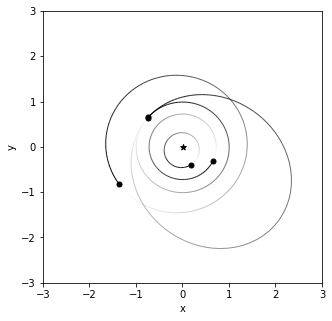

In [7]:
sim.add(primary=sim.particles[0],a=a,e=e,pomega=pomega,f=f)
rebound.OrbitPlot(sim,lim=3)

And then integrate it forward in time. Here, we use the high precision integrator IAS15. You can experiment with other integrators which might be faster, but since this is an eccentric orbit, it might leas to many close encounters, so you either need a non-symplectic integrator such as IAS15 or a hybrid integrator (try MERCURIUS).

In [8]:
# integrate
import numpy as np
sim.integrator="ias15"  
N = 1000
times = np.linspace(0.,1e5,N)
a = np.zeros(N)
e = np.zeros(N)
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    orbit = sim.particles[-1].calculate_orbit(primary=sim.particles[0])
    a[i] = orbit.a
    e[i] = orbit.e

Let's plot the orbital parameters!

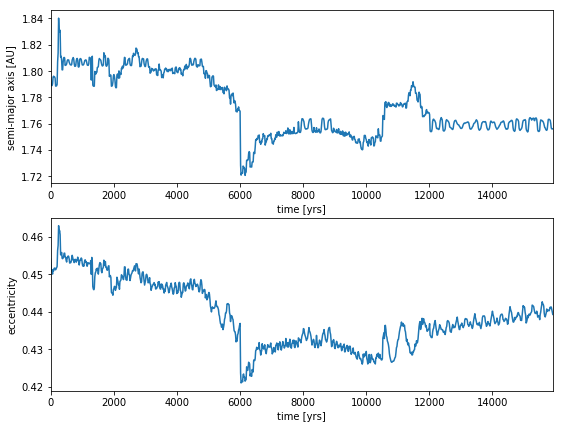

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(211)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("semi-major axis [AU]")
plt.plot(times/2./np.pi,a)
ax = plt.subplot(212)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity")
plt.plot(times/2./np.pi,e);